In [39]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")

# Technical Analysis library
#import ta

# Neural Network library
import tensorflow as tf
import tensorflow_probability as tfp
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from tensorflow import keras
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [3]:
df = pd.read_csv("top50-Stock_LogReturn.csv", index_col="Date")
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [4]:
train_len = len(train)
test_len = len(test)
print(train_len, test_len)

4212 1053


In [5]:
xc_train = np.empty((train_len - 80, 60, 50))
xf_train = np.empty((train_len - 80, 20, 50))

xc_test = np.empty((test_len - 80, 60, 50))
xf_test = np.empty((test_len - 80, 20, 50))

In [6]:
print("xc_train : ", xc_train.shape)
print("xf_train : ", xf_train.shape)
print("xc_test : ", xc_test.shape)
print("xf_test : ", xf_test.shape)

xc_train :  (4132, 60, 50)
xf_train :  (4132, 20, 50)
xc_test :  (973, 60, 50)
xf_test :  (973, 20, 50)


In [7]:
temp_xc_train = train[0: 60]
temp_xf_train = train[60 : 80]

In [8]:
for i in range(train_len - 80):
    temp_xc_train = train[i : i+60]
    temp_xf_train = train[i+60 : i+80]

    xc_train[i] = temp_xc_train
    xf_train[i] = temp_xf_train

for i in range(test_len - 80):
    temp_xc_test = test[i : i+60]
    temp_xf_test = test[i+60 : i+80]

    xc_test[i] = temp_xc_test
    xf_test[i] = temp_xf_test

In [9]:
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

In [44]:
N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.1
REG_CONST = 0.1
SAVE_MODEL = 'Markowitz_network'

In [45]:
# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# MPN에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)

def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력 1 by 50
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R) 
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST # 기대 분산
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST # 규제항
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

In [46]:
# LSTM으로 Markowitz 모델을 생성한다.
xc_input = tf.keras.Input(batch_shape = (None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout = 0.2, kernel_regularizer=l2(0.01))(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)  # linear projection

# 특정 종목을 과도하게 매수하는 것을 방지하기 위해 위에서 tanh를 사용했다. 
# (over confidence 방지용). REG_CONST를 적용했기 때문에 이미 고려된 사항이지만, 
# 안전을 위해 추가했다. ex : [-3, 0.4, 0.2, +20] --> [-0.995, 0.380, 0.197, 1.0]|

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)

model = tf.keras.Model(xc_input, y_output)
model.compile(loss = markowitz_objective, optimizer = Adam(learning_rate = 1e-6))

In [ ]:
from keras import callbacks
# # MPN을 학습하고 결과를 저장한다.
for i in range(7, 10):
  ealry_stopping = EarlyStopping(monitor='val_loss', patience=10)
  hist = model.fit(xc_train, xf_train, epochs=100, batch_size = 32, validation_data = (xc_test, xf_test), callbacks=[ealry_stopping])
  model.save(SAVE_MODEL + "_" + str(i) + '.h5')
  print(hist.history['loss'][-1], hist.history['val_loss'][-1])

In [65]:
SAVE_MODEL + "_" + str(i) + '.h5'

'Markowitz_network_7.h5_0.h5'

In [ ]:
# # MPN을 학습하고 결과를 저장한다.
model =  tf.keras.models.load_model('Markowitz_network_6.h5', custom_objects={'markowitz_objective': markowitz_objective})
model.compile(loss = markowitz_objective, optimizer = Adam(learning_rate = 5e-7))    
hist = model.fit(xc_train, xf_train, epochs=300, batch_size = 32, validation_data = (xc_test, xf_test), callbacks=[ealry_stopping])
model.save(SAVE_MODEL + "_" + str(i) + '.h5')
print(hist.history['loss'][-1], hist.history['val_loss'][-1])

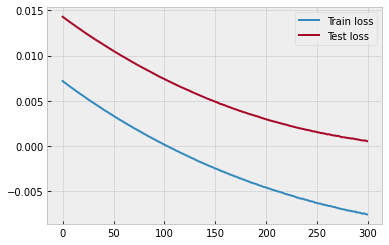

In [64]:
# loss trajectory를 확인한다.
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 379ms/step


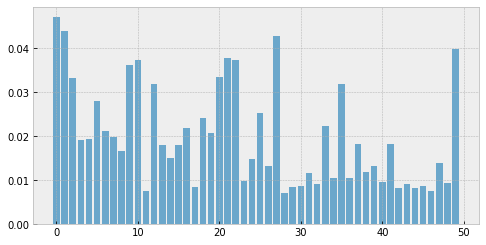

In [66]:
# 최적 포트폴리오 결과 조회용 코드

def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

In [ ]:
xc_train = np.empty((train_len - 100, 70, 50))
xf_train = np.empty((train_len - 100, 30, 50))

xc_test = np.empty((test_len - 100, 70, 50))
xf_test = np.empty((test_len - 100, 30, 50))

for i in range(train_len - 100):
    temp_xc_train = train[i : i+70]
    temp_xf_train = train[i+70 : i+100]

    xc_train[i] = temp_xc_train
    xf_train[i] = temp_xf_train

for i in range(test_len - 100):
    temp_xc_test = test[i : i+70]
    temp_xf_test = test[i+70 : i+100]

    xc_test[i] = temp_xc_test
    xf_test[i] = temp_xf_test

In [68]:
from tensorflow.python.keras.models import load_model

N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = '/content/Markowitz_network_7.h5_0.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
for i in range(0, xc_test.shape[0], N_FUTURE):
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0], N_FUTURE)
#idx = np.append(idx, 980)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value})

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 60, 50)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3250      
_________________________________________________________________
activation_4 (Activation)    (None, 50)                0         
Total params: 32,690
Trainable params: 32,690
Non-trainable params: 0
_________________________________________________________________


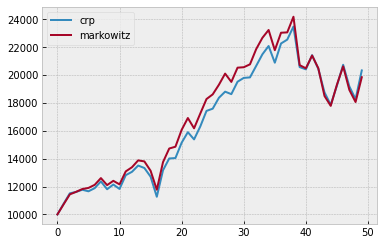

In [69]:
perf_df.plot()